# Тестовое Сбер DS & DE

## Ответы на вопросы

**Чем логистическая регрессия отличается от линейной?**  

Логистическая регрессия решает задачу классификации, линейная регрессия задачу регрессии.  
Логистическая регрессия предсказывает вероятность отнесения объекта к тому или иному классу.  
Линейная регрессия предсказывает непрерывную величину.




**Чем градиентный спуск отличается от стохастического градиентного спуска?**  

Градиентный спуск использует для поиска решения весь обучающий набор данных на каждом шаге алгоритма.  
Стохастический градиентный спуск на каждом шаге выбирает из обучающегося набора один образец и вычисляет градиент только для этого образца.  



**Какие компоненты входят в тройное экспоненциальное сглаживание временного ряда?**
1. Сглаженное значение наблюдения
2. Сглаженное значение тренда
3. Сглаженное значение сезонности


**Известные Вам метрики качества для классификации и регрессии?**  

*Метрики для классификации:*
1. Accuracy(правильность) - коэффициент корректных прогнозов.
2. Precision(точность) - отношение количества истинно положительных результатов к общему числу отмеченных моделью положительных результатов.
3. Recall(полнота) - отношение количества истинно положительных результатов к истинному количеству положительных результатов.
4. F1 - среднее гармоническое точности и полноты
5. ROC-AUC - площадь под кривой ROC (отношение долей истинно положительных результатов к доле ложноположительных)


*Метрики для регресси:*
1. MAE - средним абсолютным отклонением
2. MSE - среднеквадратическая ошибка
3. RMSE - квадратный корень из среднеквадратической ошибки
4. R2 - коэффициент детерминации. Вычисляется, как единица минус доля отношения MSE моедли к MSE среднего 

**Для чего нужна регуляризация?**

Регуляризация используется для упрощения модели и снижении риска ее переобучения. Достигается ограничением весов или степеней свободы модели.

In [ ]:
!pip install catboost

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import catboost
from geopy.distance import geodesic
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from statsmodels.distributions.empirical_distribution import ECDF
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
df = pd.read_excel('/content/taxi.xlsx')

# Изучение данных

In [ ]:
df.head()

,offer_gk,weekday_key,hour_key,driver_gk,order_gk,driver_latitude,driver_longitude,origin_order_latitude,origin_order_longitude,distance_km,duration_min,offer_class_group,ride_type_desc,driver_response
0,1105373,5,20,6080,174182,55.818842,37.334562,55.814567,37.355010,-1.000,-1.000,Economy,private,0
1,759733,5,14,6080,358774,55.805342,37.515023,55.819329,37.466398,18.802,25.217,Standard,private,1
2,416977,6,14,6080,866260,55.813978,37.347688,55.814827,37.354074,6.747,9.800,Economy,private,0
3,889660,2,6,6080,163522,55.745922,37.421748,55.743469,37.431130,-1.000,-1.000,Economy,private,1
4,1120055,4,16,6080,506710,55.803578,37.521602,55.812559,37.527407,12.383,19.250,Economy,private,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   offer_gk                100000 non-null  int64  
 1   weekday_key             100000 non-null  int64  
 2   hour_key                100000 non-null  int64  
 3   driver_gk               100000 non-null  int64  
 4   order_gk                100000 non-null  int64  
 5   driver_latitude         100000 non-null  float64
 6   driver_longitude        100000 non-null  float64
 7   origin_order_latitude   100000 non-null  float64
 8   origin_order_longitude  100000 non-null  float64
 9   distance_km             100000 non-null  float64
 10  duration_min            100000 non-null  float64
 11  offer_class_group       100000 non-null  object 
 12  ride_type_desc          100000 non-null  object 
 13  driver_response         100000 non-null  int64  
dtypes: float64(6), int64(

In [ ]:
df.duplicated().sum()

0

In [ ]:
df.describe()

,offer_gk,weekday_key,hour_key,driver_gk,order_gk,driver_latitude,driver_longitude,origin_order_latitude,origin_order_longitude,distance_km,duration_min,driver_response
count,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,5.662189e+05,3.159860,13.827790,3446.376360,460867.01291,55.700824,37.492292,55.772440,37.541637,18.393518,23.134841,0.492480
std,3.259360e+05,2.054222,7.306496,2038.738677,266064.98953,2.135903,1.454640,0.665985,0.467758,41.129296,33.890105,0.499946
min,4.000000e+00,0.000000,0.000000,14.000000,18.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000
25%,2.855552e+05,1.000000,8.000000,1421.000000,229178.50000,55.708651,37.413497,55.708032,37.407117,-1.000000,-1.000000,0.000000
50%,5.656715e+05,3.000000,16.000000,3506.500000,462420.00000,55.772904,37.533664,55.772561,37.532537,10.411500,19.700000,0.000000
75%,8.487198e+05,5.000000,20.000000,5242.000000,690894.00000,55.960667,37.624113,55.962000,37.624358,30.665250,37.867000,1.000000
max,1.130355e+06,6.000000,23.000000,6806.000000,920344.00000,56.174097,38.280547,56.311121,38.243608,5234.283000,3958.283000,1.000000


In [ ]:
df.nunique()

offer_gk                  100000
weekday_key                    7
hour_key                      24
driver_gk                    439
order_gk                   81435
driver_latitude            57259
driver_longitude           59906
origin_order_latitude      32925
origin_order_longitude     33646
distance_km                31297
duration_min                4728
offer_class_group              9
ride_type_desc                 4
driver_response                2
dtype: int64

В данных 100000 строк, явных пропусков значений в таблице нет. Дубликаты отсутствуют.  
Прзнаки:
* offer_gk - уникальные номера предложений.  
* weekday_key - день недели.
* hour_key - время заказа.
* driver_gk - уникальный номер водителя, всего в выборке 439 значений.
* order_gk - уникальный номер заказа, всего 81435 значений.
* driver_latitude  - координаты широты водителя, есть некорректные значения(-1).
* driver_longitude - координаты долготы водителя, есть некорректные значения(-1).
* origin_order_latitude - координаты широты клиента, есть некорректные значения(-1).
* origin_order_longitude - координаты долготы клиента, есть некорректные значения(-1).
* distance_km - расчетное расстояние заказа в км, есть некорректные и аномально большие значения.
* duration_min - расчетное время заказа в мин, есть некорректные и аномально большие значения.
* offer_class_group  - класс заказа, 9 типов
* ride_type_desc - тип поездки, 4 типа
* driver_response - реакция водителя

Некорректные значения в координатах, расстоянии и времени, вероятно всего образовались из-за пропусков.  
Предположу, что пропуски возникли из-за сбоев программы, либо из-за отказов клиентов.

In [ ]:
df['offer_class_group'].value_counts(normalize=True) * 100

Economy     48.335
Standard    47.288
Premium      1.773
Delivery     1.290
Kids         0.588
XL           0.464
VIP          0.225
VIP+         0.029
Test         0.008
Name: offer_class_group, dtype: float64

95% заказов представлена классами - Economy и Standard.

In [ ]:
df['ride_type_desc'].value_counts(normalize=True) * 100

private      91.207
business      8.533
affiliate     0.224
SMB           0.036
Name: ride_type_desc, dtype: float64

91% заказов приходится на тип поездки - Private

In [ ]:
df['weekday_key'].value_counts(normalize=True) * 100

5    19.284
6    15.466
0    14.411
4    13.290
1    13.089
2    12.859
3    11.601
Name: weekday_key, dtype: float64

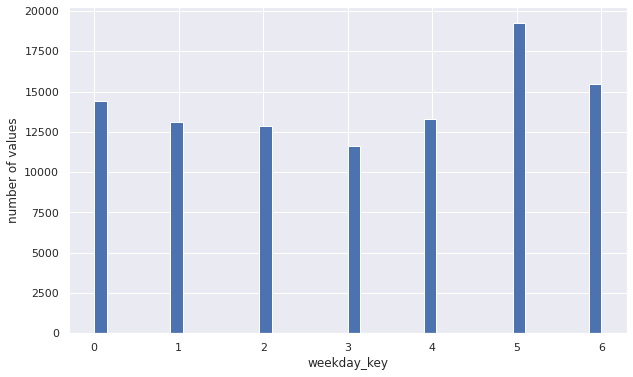

In [ ]:
plt.hist(df['weekday_key'], bins=40)
plt.xlabel('weekday_key')
plt.ylabel('number of values')
plt.show()

Самые популярные дни поездок выходные.

In [ ]:
df['hour_key'].value_counts(normalize=True) * 100

23    8.184
21    7.398
22    6.881
0     6.646
20    6.566
19    6.369
18    5.889
17    5.028
16    4.500
15    4.249
14    3.584
8     3.550
1     3.467
13    3.355
9     3.298
12    3.169
11    2.890
10    2.840
7     2.482
2     2.275
4     2.193
5     1.809
3     1.768
6     1.610
Name: hour_key, dtype: float64

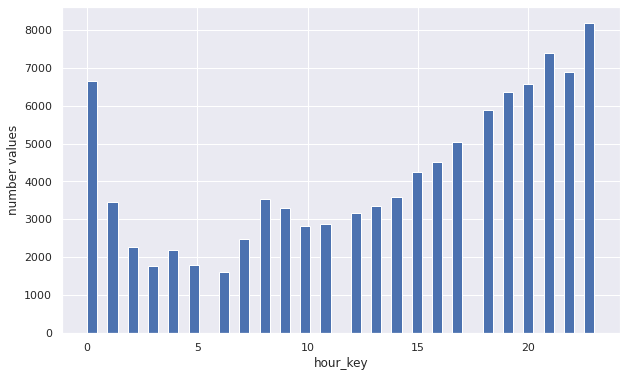

In [ ]:
plt.hist(df['hour_key'], bins=50)
plt.xlabel('hour_key')
plt.ylabel('number values')
plt.show()

Основная часть заказов приходится на вечернее с 17:00 до 00:00 часов.

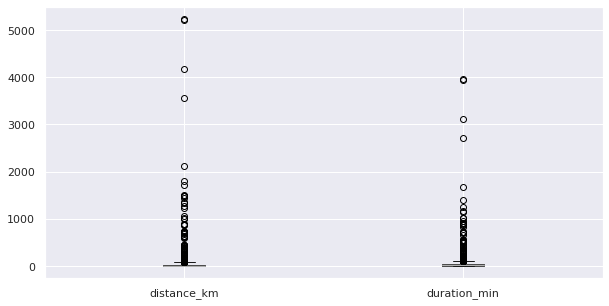

In [ ]:
boxplot = df.boxplot(column=['distance_km', 'duration_min'], figsize=(10,5))

Присутсвует большое количество аномально больших значений в расстоянии и времени заказа. 

## Оценим распределение реакций водителя `driver_response` для различных признаков

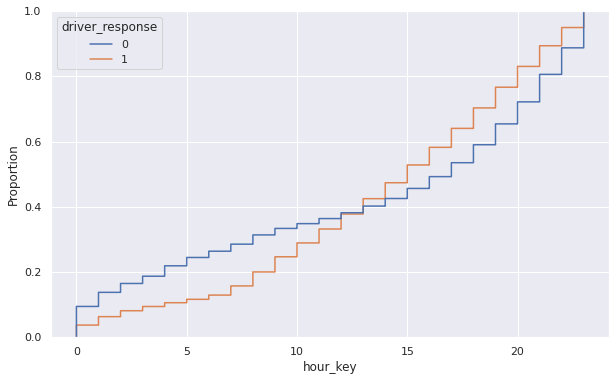

In [ ]:
sns.set(rc={'figure.figsize':(10,6)})
sns.ecdfplot(data=df, x="hour_key", hue="driver_response", stat='proportion');

Как видно из графика, пропорция заказов изменяется в течении суток. В утренние часы водители чаще не берут заказ, а во второй половине дня и в вечернее время пропорция отказов уменьшается.

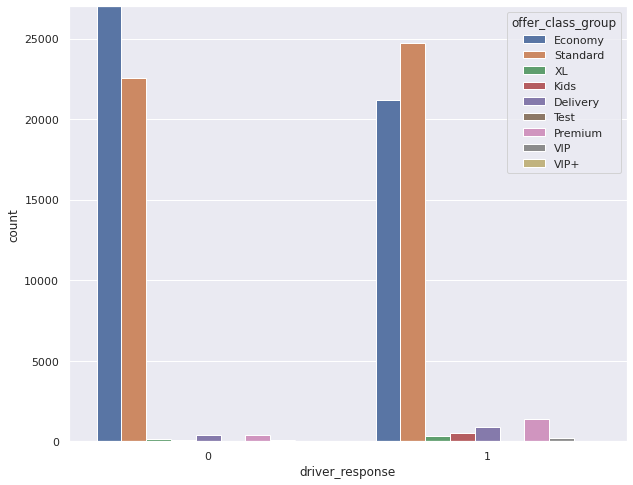

In [ ]:
fig, ax=plt.subplots(figsize=(10,8))
sns.countplot(x='driver_response', data=df, hue='offer_class_group')
ax.set_ylim(0,27000)
plt.show()

Количество отказов водителей в эконом сегменте выше, чем в других.  
Количество положительных реакций выше в сегменет стандарт.

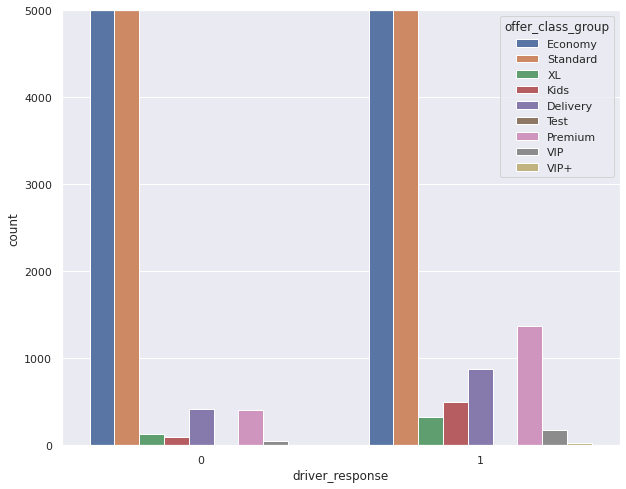

In [ ]:
fig, ax=plt.subplots(figsize=(10,8))
sns.countplot(x='driver_response', data=df, hue='offer_class_group')
ax.set_ylim(0,5000)
plt.show()

Распределения положительного и отрицательного класса различается, особенно в более дорогих сегментах.

## Оценим среднее распределение положительных реакций водителей в группах с пропусками и без них

In [ ]:
len(df[df['distance_km'] < 1])

26682

In [ ]:
df_new = df.query('distance_km > 1')

In [ ]:
df_exp = pd.pivot_table(df_new,
               index=['driver_gk'],
               values=['driver_response'],
               aggfunc=['mean']
               ).reset_index()

In [ ]:
df_exp.columns = ['driver_gk', 'mean_driver_response']

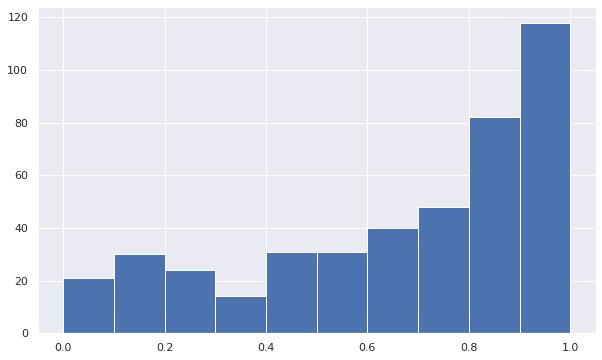

In [ ]:
df_exp['mean_driver_response'].hist();

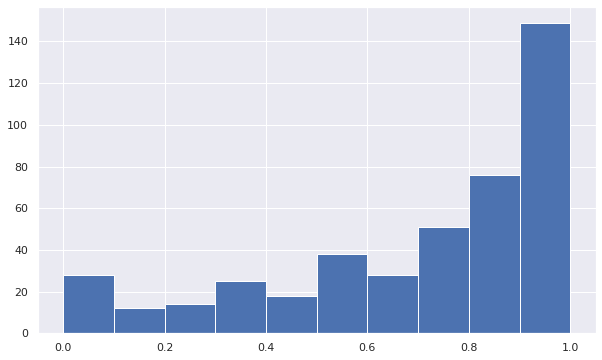

In [ ]:
df.query('distance_km < 1').groupby('driver_gk')['driver_response'].agg('mean').hist();

Рапределения очень похожи. Следовательно, связи с появление пропусков и реакцией водителя нет.


# Вывод

DataFrame состоит из 100000 строк.  Дубликаты отсутствуют.  
При анализе данных были выявлены аномально большие значения и пропуски.  
Требуется уточнения у разроботчиков, в результате чего могут возникнуть не характерные значения. 

#Baseline models

Построим модели без предварительной очистки.  
Для модели CatBoost используем данные без преобразования, а для моделей LogisticRegression и DecisionTreeClassifier применим к признакам метод One Hot Encoder. 

В качестве метрик выберем f1 score и ROC_AUC.  

Метрика f1 это среднее гармоническое точности и полноты, в результате классификатор покажет более высокое значение f1, только в случае высоких мер точности(precision) и полноты(recall).  

ROC_AUC это площадь под кривой ROC. Кривая ROC показывает долю истинно положительных к доле ложноотрицательных классификаций модели.


In [ ]:
features = df.drop(['driver_response'], axis=1)
target = df['driver_response']

In [ ]:
# отделим 20% данных для тестовой выборки
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.20, random_state=12345)

In [ ]:
print(features.shape)
print(features_train.shape)
print(features_test.shape)

(100000, 13)
(80000, 13)
(20000, 13)


## One Hot Encoder (OHE)

Для моделей LogisticRegression и DecisionTreeClassifier требуется, чтобы признаки имели числовой формат.  
Преобразуем категориальные признаки с помощью метода OHE:

In [ ]:
ohe_features = pd.get_dummies(features, drop_first=True)

In [ ]:
# отделим 20% данных для тестовой выборки
ohe_features_train, ohe_features_test, target_train, target_test = train_test_split(
    ohe_features, target, test_size=0.20, random_state=12345)

## LogisticRegression Baseline

In [ ]:
%%time

lr = LogisticRegression(random_state=12345) 
scores_lr = cross_val_score(lr, ohe_features_train, target_train, 
                              scoring='f1', cv=5)
f1_scores_lr = scores_lr.mean()
print('Среднее значение F1 при кросс-валидации LogisticRegression =', f1_scores_lr)

Среднее значение F1 при кросс-валидации LogisticRegression = 0.3173841891360586
CPU times: user 2.82 s, sys: 1.28 s, total: 4.1 s
Wall time: 2.25 s


In [ ]:
lr.fit(ohe_features_train, target_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=12345, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
print(classification_report(target_test, lr.predict(ohe_features_test)))

              precision    recall  f1-score   support

           0       0.51      0.91      0.65     10141
           1       0.49      0.08      0.14      9859

    accuracy                           0.50     20000
   macro avg       0.50      0.50      0.40     20000
weighted avg       0.50      0.50      0.40     20000



In [ ]:
probabilities = lr.predict_proba(ohe_features_test)

In [ ]:
fpr, tpr, thresholds = roc_curve(target_test, probabilities[:,1])

In [ ]:
auc_roc_lr = roc_auc_score(target_test, probabilities[:,1])

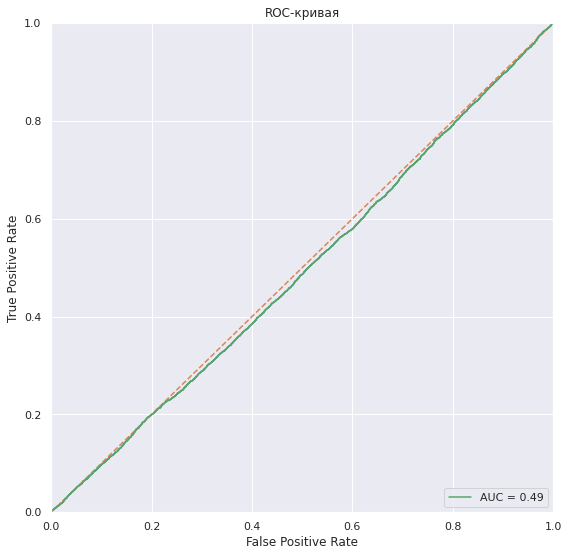

In [ ]:
plt.figure(figsize=(9,9))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--') # ROC-кривая случайной модели
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.plot(fpr, tpr, 'g', label = 'AUC = %0.2f' % auc_roc_lr)
plt.legend(loc = 'lower right')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-кривая")
plt.grid(True)
plt.show()

Модель линейной регрессии предсказывает значение хуже, чем случайная. Необходимо провести анализ фичей.

## DecisionTreeClassifier Baseline

In [ ]:
%%time

dtc = DecisionTreeClassifier(random_state=12345) 
scores_dtc = cross_val_score(dtc, ohe_features_train, target_train, 
                              scoring='f1', cv=5)
f1_scores_dtc = scores_dtc.mean()
print('Среднее значение F1 при кросс-валидации DecisionTreeClassifier =', f1_scores_dtc)

Среднее значение F1 при кросс-валидации DecisionTreeClassifier = 0.7403407762727043
CPU times: user 6.51 s, sys: 19 ms, total: 6.53 s
Wall time: 6.51 s


In [ ]:
dtc.fit(ohe_features_train, target_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=12345, splitter='best')

In [ ]:
print(classification_report(target_test, dtc.predict(ohe_features_test)))

              precision    recall  f1-score   support

           0       0.75      0.76      0.76     10141
           1       0.75      0.74      0.75      9859

    accuracy                           0.75     20000
   macro avg       0.75      0.75      0.75     20000
weighted avg       0.75      0.75      0.75     20000



In [ ]:
probabilities = dtc.predict_proba(ohe_features_test)

In [ ]:
fpr, tpr, thresholds = roc_curve(target_test, probabilities[:,1])

In [ ]:
auc_roc_dtc = roc_auc_score(target_test, probabilities[:,1])

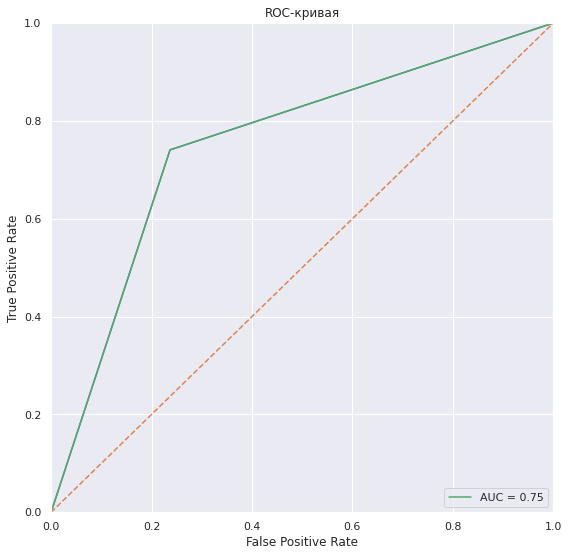

In [ ]:
plt.figure(figsize=(9,9))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--') # ROC-кривая случайной модели
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.plot(fpr, tpr, 'g', label = 'AUC = %0.2f' % auc_roc_dtc)
plt.legend(loc = 'lower right')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-кривая")
plt.grid(True)
plt.show()

Оценим важность признаков для модели:

In [ ]:
feature_dtc = pd.DataFrame(sorted(zip(dtc.feature_importances_,features_train.columns)), columns=['Value','Feature'])
feature_dtc = feature_dtc.sort_values(by="Value", ascending=False).copy()
feature_dtc

,Value,Feature
12,0.335705,origin_order_latitude
11,0.140835,driver_gk
10,0.069308,offer_gk
9,0.067958,driver_longitude
8,0.066874,order_gk
7,0.066595,driver_latitude
6,0.061760,origin_order_longitude
5,0.049885,distance_km
4,0.045854,hour_key
3,0.041838,duration_min


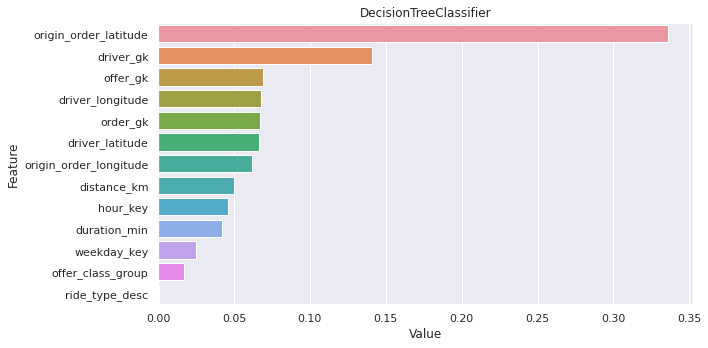

In [ ]:
plt.figure(figsize=(10, 5))
sns.barplot(x="Value", y="Feature", data=feature_dtc)
plt.title('DecisionTreeClassifier')
plt.tight_layout()
plt.show()

## CatBoost Baseline

In [ ]:
%%time
cat_features = ['offer_class_group', 'ride_type_desc']

cbс = CatBoostClassifier(random_state=12345,
                        cat_features=cat_features,
                        verbose=200, 
                       early_stopping_rounds=600) 
scores_cbс = cross_val_score(cbс, features_train, target_train, 
                              scoring='f1', cv=5)
f1_scores_cbс = scores_cbс.mean()
print('Среднее значение F1 при кросс-валидации CatBoostClassifier =', f1_scores_cbс)

Learning rate set to 0.060838
0:	learn: 0.6709410	total: 82.1ms	remaining: 1m 21s
200:	learn: 0.4521844	total: 13.3s	remaining: 52.7s
400:	learn: 0.4210187	total: 26.3s	remaining: 39.2s
600:	learn: 0.4024061	total: 39.4s	remaining: 26.1s
800:	learn: 0.3870959	total: 52.3s	remaining: 13s
999:	learn: 0.3743548	total: 1m 5s	remaining: 0us
Learning rate set to 0.060838
0:	learn: 0.6715532	total: 66.1ms	remaining: 1m 6s
200:	learn: 0.4545034	total: 13s	remaining: 51.9s
400:	learn: 0.4229340	total: 26.1s	remaining: 39s
600:	learn: 0.4031617	total: 39.2s	remaining: 26s
800:	learn: 0.3882512	total: 52s	remaining: 12.9s
999:	learn: 0.3746245	total: 1m 5s	remaining: 0us
Learning rate set to 0.060838
0:	learn: 0.6711322	total: 64.1ms	remaining: 1m 4s
200:	learn: 0.4511338	total: 13.2s	remaining: 52.3s
400:	learn: 0.4211970	total: 26.1s	remaining: 39s
600:	learn: 0.4021724	total: 39.2s	remaining: 26s
800:	learn: 0.3868078	total: 52.2s	remaining: 13s
999:	learn: 0.3731139	total: 1m 5s	remaining: 0u

In [ ]:
cbс.fit(features_train, target_train)

Learning rate set to 0.06692
0:	learn: 0.6677328	total: 97.6ms	remaining: 1m 37s
200:	learn: 0.4485664	total: 15.9s	remaining: 1m 3s
400:	learn: 0.4203583	total: 31.8s	remaining: 47.5s
600:	learn: 0.4013568	total: 47.7s	remaining: 31.6s
800:	learn: 0.3860828	total: 1m 3s	remaining: 15.8s
999:	learn: 0.3747165	total: 1m 19s	remaining: 0us


In [ ]:
probabilities = cbс.predict_proba(features_test)

In [ ]:
print(classification_report(target_test, cbс.predict(features_test)))

              precision    recall  f1-score   support

           0       0.86      0.78      0.82     10141
           1       0.79      0.87      0.83      9859

    accuracy                           0.82     20000
   macro avg       0.83      0.82      0.82     20000
weighted avg       0.83      0.82      0.82     20000



In [ ]:
fpr, tpr, thresholds = roc_curve(target_test, probabilities[:,1])

In [ ]:
auc_roc_cbc = roc_auc_score(target_test, probabilities[:,1])

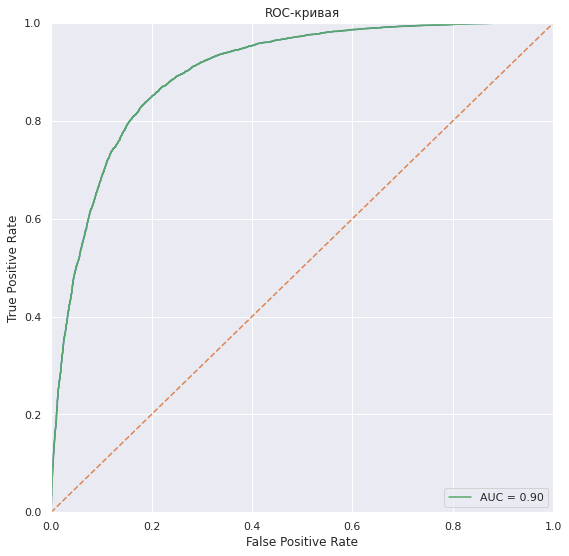

In [ ]:
plt.figure(figsize=(9,9))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--') # ROC-кривая случайной модели
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.plot(fpr, tpr, 'g', label = 'AUC = %0.2f' % auc_roc_cbc)
plt.legend(loc = 'lower right')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-кривая")
plt.grid(True)
plt.show()

Оценим важность признаков для модели:

In [ ]:
feature_cbс = pd.DataFrame(sorted(zip(cbс.feature_importances_,features_train.columns)), columns=['Value','Feature'])
feature_cbс = feature_cbс.sort_values(by="Value", ascending=False).copy()
feature_cbс

,Value,Feature
12,35.217639,driver_gk
11,14.067565,driver_latitude
10,12.547824,origin_order_latitude
9,8.065972,driver_longitude
8,6.512566,offer_class_group
7,5.564459,hour_key
6,5.486470,origin_order_longitude
5,4.520405,distance_km
4,2.802496,duration_min
3,2.450305,weekday_key


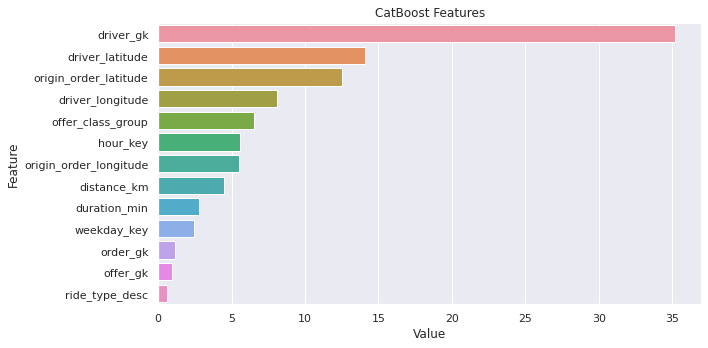

In [ ]:
plt.figure(figsize=(10, 5))
sns.barplot(x="Value", y="Feature", data=feature_cbс)
plt.title('CatBoost Features')
plt.tight_layout()
plt.show()

In [ ]:
data_baseline_model = pd.DataFrame({'baseline_f1':[f1_scores_lr,f1_scores_dtc, f1_scores_cbс],
                                    'baseline_auc_roc':[auc_roc_lr,auc_roc_dtc,auc_roc_cbc]},
                                   index=['LogisticRegression','DecisionTreeClassifier','CatBoost'])
data_baseline_model

,baseline_f1,baseline_auc_roc
LogisticRegression,0.317384,0.491139
DecisionTreeClassifier,0.740341,0.751942
CatBoost,0.825677,0.899569


# Вывод

Обучено 3 модели LogisticRegression, DecisionTreeClassifier, CatBoost без настройки гиперпараметров и очистки данных.  
Модель CatBoost уже отлично показала себя на тестововй выборке и имеет высокие показатели метрик, но имеет слишком продолжительное время обучения.  

Из анализа важности фич, можно сделать увидеть что у признака `driver_gk` очень высокие коэффициенты. Следовательно, этот признак существенно влияет на разделение классов.


# Преобразование признаков

На данном этапе преобразуем данные следующим образом:
1. Вычислим расстояние между водителем и клиентам и избавимся от координатных фич.
2. Очистим данные от аномально больших значений в `distance_km` и `duration_min`.
3. Очистим данные от выявленных ранее пропусков.
4. Удалим признаки не несущие за собой полезную информацию.


Создадим столбец `dist_calc_km` с расчетным значением расстояния между водителем и пассажиром:

In [ ]:
# функция расчета расстояния по координатам 
def calc_dist(l11,l12,l21,l22):
  dist = geodesic((l11,l12),(l21,l22)).km
  return dist

In [ ]:
df['dist_calc_km'] = df.apply(lambda x: calc_dist(x['driver_latitude'], x['driver_longitude'], x['origin_order_latitude'], x['origin_order_longitude']), axis = 1).round(3)

In [ ]:
df.sample(3)

,offer_gk,weekday_key,hour_key,driver_gk,order_gk,driver_latitude,driver_longitude,origin_order_latitude,origin_order_longitude,distance_km,duration_min,offer_class_group,ride_type_desc,driver_response,dist_calc_km
48501,1105540,3,23,6051,851292,55.809396,37.578683,55.800124,37.585705,-1.000,-1.000,Standard,business,1,1.122
58922,1112434,5,16,6304,64799,55.716492,37.608278,55.720932,37.600693,5.960,10.300,Economy,private,1,0.687
87009,718552,2,1,235,519631,55.414628,37.898778,55.410307,37.902451,51.214,57.667,Economy,private,0,0.534


Удалим пропуски в координатах:

In [ ]:
df_full = df.query('driver_latitude > 1  \
                       and driver_longitude > 1 \
                       and origin_order_latitude > 1 \
                       and origin_order_longitude > 1')

In [ ]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99846 entries, 0 to 99999
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   offer_gk                99846 non-null  int64  
 1   weekday_key             99846 non-null  int64  
 2   hour_key                99846 non-null  int64  
 3   driver_gk               99846 non-null  int64  
 4   order_gk                99846 non-null  int64  
 5   driver_latitude         99846 non-null  float64
 6   driver_longitude        99846 non-null  float64
 7   origin_order_latitude   99846 non-null  float64
 8   origin_order_longitude  99846 non-null  float64
 9   distance_km             99846 non-null  float64
 10  duration_min            99846 non-null  float64
 11  offer_class_group       99846 non-null  object 
 12  ride_type_desc          99846 non-null  object 
 13  driver_response         99846 non-null  int64  
 14  dist_calc_km            99846 non-null

Т.к. в признаках `distance_km` и `duration_min` имеются значения 0 и -1 и нет информации что они означают, удалим их из выборки. Также удалим выбросы из этих признаков.

In [ ]:
df_full['duration_min'].quantile(.999)

110.35

In [ ]:
df_full['distance_km'].quantile(.999)

129.11258500000412

In [ ]:
len(df_full.query('distance_km < 1 and duration_min < 1'))

26269

In [ ]:
df_full = df_full.query('distance_km > 1 and duration_min > 1 and distance_km < 200 and duration_min < 200 and dist_calc_km > 0')

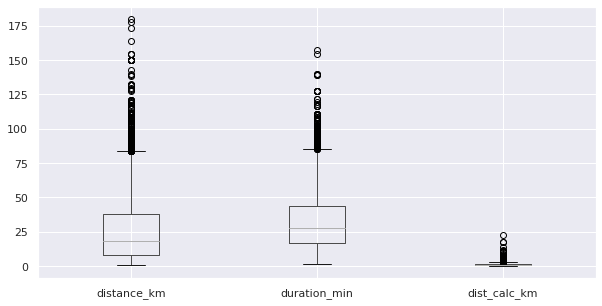

In [ ]:
boxplot = df_full.boxplot(column=['distance_km', 'duration_min', 'dist_calc_km'], figsize=(10,5))

In [ ]:
(1-len(df_full) / len(df)) * 100

28.589

Удалим лишние признаки:

In [ ]:
features = df_full.drop(['offer_gk', 'order_gk', 'driver_response', 'driver_latitude', 'driver_longitude', 'origin_order_latitude', 'origin_order_longitude'], axis=1)
target = df_full['driver_response']

In [ ]:
features.tail()

,weekday_key,hour_key,driver_gk,distance_km,duration_min,offer_class_group,ride_type_desc,dist_calc_km
99995,0,2,2442,17.378,29.817,Economy,private,0.623
99996,0,1,2442,7.751,12.683,Economy,private,0.406
99997,1,20,2442,46.983,46.217,Standard,private,0.205
99998,6,21,2442,50.029,51.100,Economy,private,0.394
99999,0,23,2442,54.811,56.183,Standard,private,0.435


In [ ]:
features.shape

(71411, 8)

# Вывод

Учитывая имеющуюся информацию, мы провели преобразование и очистку данных.  
Мы потеряли более 28% данных, но все еще имеем достаточно большое количество значений для построения моделей.  
В случае получения достоверной информации о происхождении значений 0, -1 и аномально больших значениях, стратегия очистки данных может быть изменена.  
Количество признаков для обучения моделей сократилось с 16 до 8.



# Построение моделей на подготовленных данных

In [ ]:
# отделим 20% данных для тестовой выборки
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.20, random_state=12345)

In [ ]:
print(features_train.shape[0] + features_test.shape[0])
print(features.shape)

71411
(71411, 8)


Применим метод OHE для категориальных признаков:

In [ ]:
ohe_features = pd.get_dummies(features, drop_first=True)

In [ ]:
# отделим 20% данных для тестовой выборки
ohe_features_train, ohe_features_test, target_train, target_test = train_test_split(
    ohe_features, target, test_size=0.20, random_state=12345)

In [ ]:
print(ohe_features_train.shape[0] + ohe_features_test.shape[0])
print(features.shape)

71411
(71411, 8)


## LogisticRegression

In [ ]:
%%time

lr = LogisticRegression(random_state=12345, max_iter=500) 
scores_lr = cross_val_score(lr, ohe_features_train, target_train, 
                              scoring='f1', cv=5)
f1_scores_lr = scores_lr.mean()
print('Среднее значение F1 при кросс-валидации LogisticRegression =', f1_scores_lr)

Среднее значение F1 при кросс-валидации LogisticRegression = 0.692598457572443
CPU times: user 9.25 s, sys: 5.76 s, total: 15 s
Wall time: 7.76 s


In [ ]:
lr.fit(ohe_features_train, target_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=500,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=12345, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
print(classification_report(target_test, lr.predict(ohe_features_test)))

              precision    recall  f1-score   support

           0       0.73      0.64      0.68      7483
           1       0.65      0.74      0.69      6800

    accuracy                           0.68     14283
   macro avg       0.69      0.69      0.68     14283
weighted avg       0.69      0.68      0.68     14283



In [ ]:
probabilities = lr.predict_proba(ohe_features_test)

In [ ]:
fpr, tpr, thresholds = roc_curve(target_test, probabilities[:,1])

In [ ]:
auc_roc_lr = roc_auc_score(target_test, probabilities[:,1])

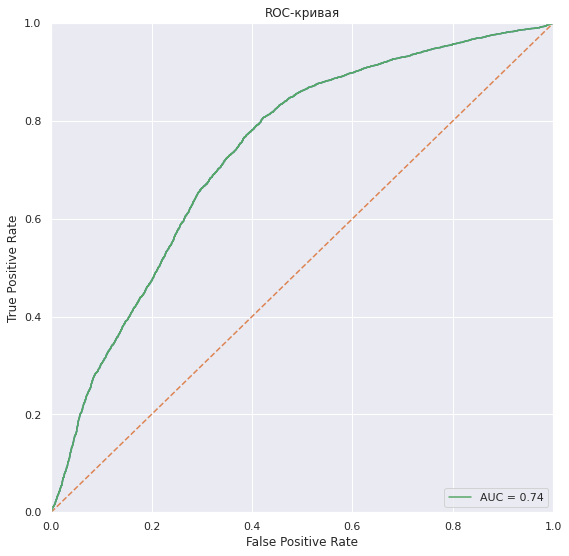

In [ ]:
plt.figure(figsize=(9,9))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--') # ROC-кривая случайной модели
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.plot(fpr, tpr, 'g', label = 'AUC = %0.2f' % auc_roc_lr)
plt.legend(loc = 'lower right')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-кривая")
plt.grid(True)
plt.show()

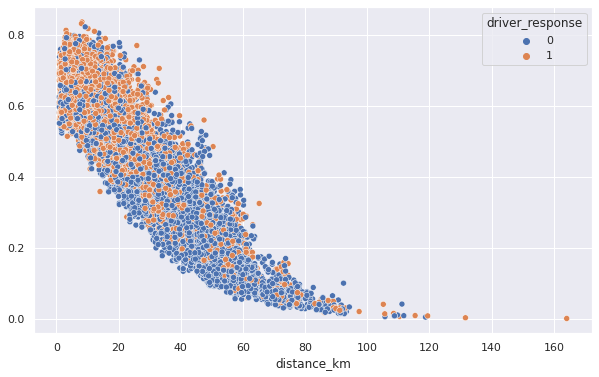

In [ ]:
sns.scatterplot(x = ohe_features_test['distance_km'], y=probabilities[:,1], hue=target_test);

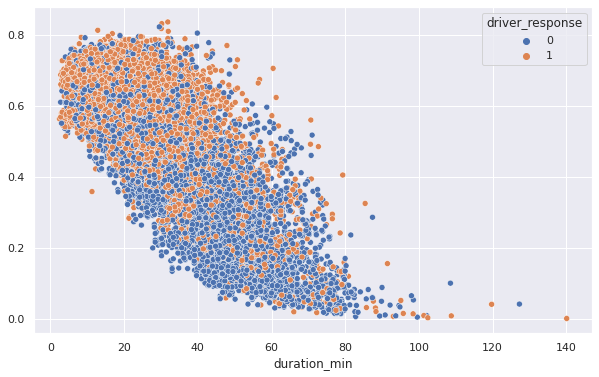

In [ ]:
sns.scatterplot(x = ohe_features_test['duration_min'], y=probabilities[:,1], hue=target_test);

Предсказания модели линейной регрессии значительно улучшились.  
На графиках видно, что модель предсказывает положительный класс для поездок на короткие расстояния и не большие по времени.

## DecisionTreeClassifier

Используем GridSearch для поиска оптимальных параметров модели:

In [ ]:
%%time

params_grid = {'max_depth': np.arange(1,30,5),
                'random_state':[12345],
                'criterion':['gini','entropy'],
                 }
dtc = DecisionTreeClassifier()
dtc_gs = GridSearchCV(dtc, param_grid=params_grid,
                          cv=5, scoring='f1')

dtc_gs.fit(ohe_features_train, target_train)

print(f'Лучшее значение F1 при GridSearchCV {dtc_gs.best_score_}')
print(f'Лучшие параметры модели: {dtc_gs.best_params_}')

Лучшее значение F1 при GridSearchCV 0.7431658530081198
Лучшие параметры модели: {'criterion': 'entropy', 'max_depth': 11, 'random_state': 12345}
CPU times: user 20.4 s, sys: 71.7 ms, total: 20.4 s
Wall time: 20.3 s


In [ ]:
dtc = DecisionTreeClassifier(**dtc_gs.best_params_)
dtc.fit(ohe_features_train, target_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=11, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=12345, splitter='best')

In [ ]:
print(classification_report(target_test, dtc.predict(ohe_features_test)))

              precision    recall  f1-score   support

           0       0.79      0.67      0.73      7483
           1       0.69      0.80      0.74      6800

    accuracy                           0.74     14283
   macro avg       0.74      0.74      0.74     14283
weighted avg       0.74      0.74      0.73     14283



In [ ]:
probabilities = dtc.predict_proba(ohe_features_test)

In [ ]:
fpr, tpr, thresholds = roc_curve(target_test, probabilities[:,1])

In [ ]:
auc_roc_dtc = roc_auc_score(target_test, probabilities[:,1])

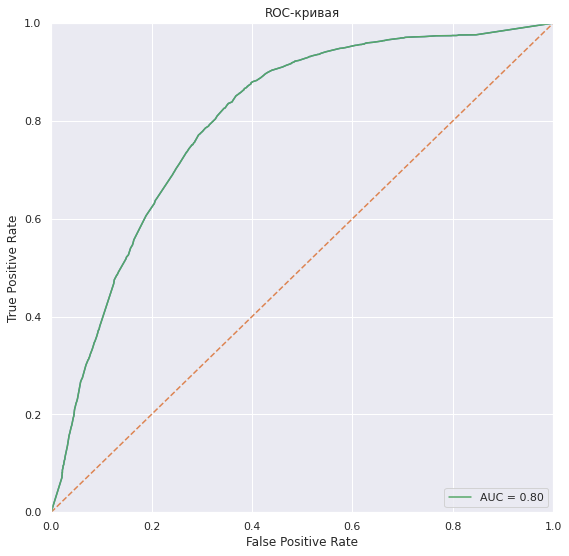

In [ ]:
plt.figure(figsize=(9,9))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--') # ROC-кривая случайной модели
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.plot(fpr, tpr, 'g', label = 'AUC = %0.2f' % auc_roc_dtc)
plt.legend(loc = 'lower right')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-кривая")
plt.grid(True)
plt.show()

In [ ]:
feature_dtc = pd.DataFrame(sorted(zip(dtc.feature_importances_,features_train.columns)), columns=['Value','Feature'])
feature_dtc = feature_dtc.sort_values(by="Value", ascending=False).copy()
feature_dtc

,Value,Feature
7,0.370649,distance_km
6,0.285182,driver_gk
5,0.147654,offer_class_group
4,0.072421,hour_key
3,0.052074,duration_min
2,0.044207,ride_type_desc
1,0.019901,weekday_key
0,0.000700,dist_calc_km


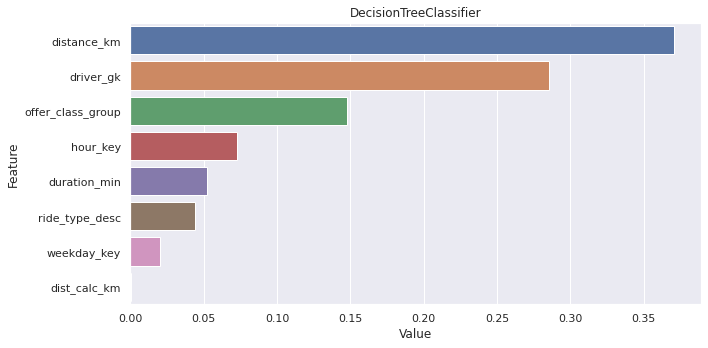

In [ ]:
plt.figure(figsize=(10, 5))
sns.barplot(x="Value", y="Feature", data=feature_dtc)
plt.title('DecisionTreeClassifier')
plt.tight_layout()
plt.show()

Метрика F1 у модели осталась прежней, метрика ROC-AUC улучшилась.

## CatBoostClassifier

Учитывая долгий алгоритм обучения CatBoost, запустим обучения без подборов гиперпараметров.

In [ ]:
cat_features = ['offer_class_group', 'ride_type_desc']

In [ ]:
%%time
cat_features = ['offer_class_group', 'ride_type_desc']

cbс = CatBoostClassifier(random_state=12345,
                        cat_features=cat_features,
                        verbose=200, 
                       early_stopping_rounds=600) 
scores_cbс = cross_val_score(cbс, features_train, target_train, 
                              scoring='f1', cv=5)
f1_scores_cbс = scores_cbс.mean()
print('Среднее значение F1 при кросс-валидации CatBoostClassifier =', f1_scores_cbс)

Learning rate set to 0.05269
0:	learn: 0.6806124	total: 48.4ms	remaining: 48.4s
200:	learn: 0.4943497	total: 9.27s	remaining: 36.8s
400:	learn: 0.4539129	total: 18.5s	remaining: 27.6s
600:	learn: 0.4300923	total: 27.7s	remaining: 18.4s
800:	learn: 0.4130161	total: 37s	remaining: 9.19s
999:	learn: 0.3996175	total: 46.3s	remaining: 0us
Learning rate set to 0.05269
0:	learn: 0.6807466	total: 45.4ms	remaining: 45.4s
200:	learn: 0.4917696	total: 9.19s	remaining: 36.5s
400:	learn: 0.4527375	total: 18.6s	remaining: 27.8s
600:	learn: 0.4286545	total: 27.9s	remaining: 18.6s
800:	learn: 0.4107769	total: 37.3s	remaining: 9.26s
999:	learn: 0.3972643	total: 46.8s	remaining: 0us
Learning rate set to 0.05269
0:	learn: 0.6807244	total: 46.3ms	remaining: 46.2s
200:	learn: 0.4964058	total: 9.07s	remaining: 36.1s
400:	learn: 0.4528357	total: 18.4s	remaining: 27.4s
600:	learn: 0.4277555	total: 27.8s	remaining: 18.4s
800:	learn: 0.4103295	total: 37s	remaining: 9.2s
999:	learn: 0.3965294	total: 46.4s	remain

In [ ]:
cbс.fit(features_train, target_train)

Learning rate set to 0.057957
0:	learn: 0.6791872	total: 55.5ms	remaining: 55.4s
200:	learn: 0.4889673	total: 11.3s	remaining: 44.9s
400:	learn: 0.4481965	total: 22.6s	remaining: 33.8s
600:	learn: 0.4247893	total: 33.8s	remaining: 22.4s
800:	learn: 0.4082900	total: 45.3s	remaining: 11.2s
999:	learn: 0.3948199	total: 56.7s	remaining: 0us


In [ ]:
probabilities = cbс.predict_proba(features_test)

In [ ]:
print(classification_report(target_test, cbс.predict(features_test)))

              precision    recall  f1-score   support

           0       0.85      0.79      0.82      7483
           1       0.79      0.84      0.81      6800

    accuracy                           0.82     14283
   macro avg       0.82      0.82      0.82     14283
weighted avg       0.82      0.82      0.82     14283



In [ ]:
fpr, tpr, thresholds = roc_curve(target_test, probabilities[:,1])

In [ ]:
auc_roc_cbc = roc_auc_score(target_test, probabilities[:,1])

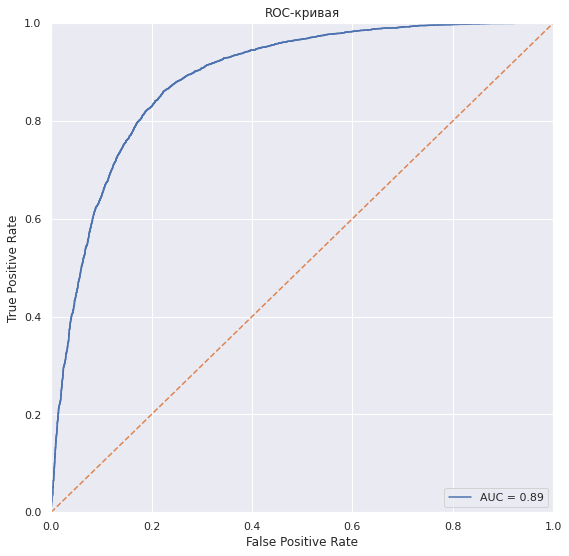

In [ ]:
plt.figure(figsize=(9,9))
plt.plot(fpr, tpr)
# ROC-кривая случайной модели
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % auc_roc_cbc)
plt.legend(loc = 'lower right')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-кривая")
plt.grid(True)
plt.show()

In [ ]:
cbr.feature_importances_

array([ 0.97475303,  2.45030519,  5.56445917, 35.21763867,  1.16730831,
       14.06756502,  8.06597199, 12.54782408,  5.48646983,  4.52040455,
        2.80249556,  6.51256562,  0.62223899])

In [ ]:
feature_cbс = pd.DataFrame(sorted(zip(cbс.feature_importances_,features_train.columns)), columns=['Value','Feature'])
feature_cbс = feature_cbс.sort_values(by="Value", ascending=False).copy()
feature_cbс

,Value,Feature
7,57.072367,driver_gk
6,14.836153,distance_km
5,9.604933,dist_calc_km
4,7.094714,hour_key
3,5.721631,offer_class_group
2,3.534410,duration_min
1,2.037039,weekday_key
0,0.098753,ride_type_desc


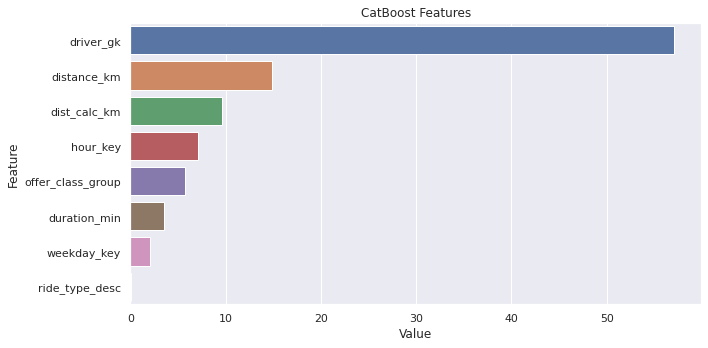

In [ ]:
plt.figure(figsize=(10, 5))
sns.barplot(x="Value", y="Feature", data=feature_cbс)
plt.title('CatBoost Features')
plt.tight_layout()
plt.show()

In [ ]:
features_test.head()

,weekday_key,hour_key,driver_gk,distance_km,duration_min,offer_class_group,ride_type_desc,dist_calc_km
93401,6,2,6554,38.940,44.933,Standard,private,0.535
72322,5,1,4605,22.993,38.667,Standard,private,0.926
76722,5,16,517,21.787,29.467,Economy,private,3.430
40496,6,0,1421,30.302,32.667,Standard,private,0.630
34611,2,15,5242,12.071,15.717,Economy,private,0.592


In [ ]:
data_model = pd.DataFrame({'f1':[f1_scores_lr,f1_scores_dtc, f1_scores_cbс],
                                    'auc_roc':[auc_roc_lr,auc_roc_dtc,auc_roc_cbc]},
                                   index=['LogisticRegression','DecisionTreeClassifier','CatBoost'])
data_model

,f1,auc_roc
LogisticRegression,0.692598,0.736419
DecisionTreeClassifier,0.740341,0.801004
CatBoost,0.807313,0.888412


In [ ]:
data_full = pd.concat([data_baseline_model, data_model], axis=1)

In [ ]:
data_full = data_full.reindex(columns=['baseline_f1', 'f1', 'baseline_auc_roc', 'auc_roc'])

In [ ]:
data_full['coef_f1'] = (data_full['f1'] / data_full['baseline_f1']).round(2)
data_full['coef_roc_auc'] = (data_full['auc_roc'] / data_full['baseline_auc_roc']).round(2)

In [ ]:
data_full

,baseline_f1,f1,baseline_auc_roc,auc_roc,coef_f1,coef_roc_auc
LogisticRegression,0.317384,0.692598,0.491139,0.736419,2.18,1.50
DecisionTreeClassifier,0.740341,0.740341,0.751942,0.801004,1.00,1.07
CatBoost,0.825677,0.807313,0.899569,0.888412,0.98,0.99


# Общий вывод  
Анализ данных показал:
1. Самые популярные дни поездок выходные.
2. Основная часть заказов приходится на вечернее с 17:00 до 00:00 часов.
3. В утренние часы водители чаще не берут заказ, а во второй половине дня и в вечернее время пропорция отказов уменьшается.
4. Распределение средних значений конверсии заказов у водителей с пропусками и без них, визуально одинаковы. Значит, что пропуски врял ли вызваны махинациями со стороны водителей. 

Первоначальные данные состояли из 100000 строк.  В ходе анализа данных, мы удалили порядка 28% данных. Данная мера была вынужденной, т.к. отсутствует понимание, как образовались отрицательные, нулевые и аномально большие значения.  
Количество признаков для обучения моделей сократилось с 16 до 8.  

Обучено 3 модели **LogisticRegression, DecisionTreeClassifier, CatBoost**.

  
Модель **LogisticRegression**.  
На первоначальных данных показала себя хуже, чем случайный алгоритм классификации. На преобразованных данных удалось увеличить метрику F1 в 2 раза и ROC-AUC в 1,5 раза.

Модель **DecisionTreeClassifier**.  
Увеличить метрику F1 с помощью преобразования данных не удалось, ROC-AUC вырос на 7%.


Модель **CatBoost**.  
Модель характеризуется самыми лучшими показателями метрик. Преобразование данных для модели *CatBoost* не много ухудшило результаты, но значительно ускорило время обучения.

Основной метрикой влияющей на предсказание является признак `driver_gk`.  Уникальный номер водителя, это та метрика от которой в первую очередь зависит отнесение объекта к тому или иному классу. 

Наиболее быстро расчет алгоритмов произвели модели LogisticRegression и DecisionTreeClassifier.  

Для решения какую модель использовать, следует определиться, что важно простота, скорость обучения, интерпретируемость моделей или точность прогноза.


**Рекомендации:**  



1. Выявить причину возникновения пропусков и аномально больших значений.
2. Выполнить подготовку уточненных данных.
3. Определиться, важна ли скорость обучения модели.
4. Провести переобучение моделей.











